In [2]:
import random
import numpy as np
import pandas as pd

# SEIR model equations with N=1 (population is normalized)
def seir_equations(y, beta, gamma, sigma, mu, nu):
    S, E, I, R = y
    N = 1  # Total population is set to 1
    dS_dt = mu * (N - S) - (beta * S * I / N) - nu * S
    dE_dt = (beta * S * I / N) - (mu + sigma) * E
    dI_dt = sigma * E - (mu + gamma) * I
    dR_dt = gamma * I - mu * R + nu * S
    return [dS_dt, dE_dt, dI_dt, dR_dt]

# Time grid
start_time = 0
end_time = 50
time_step = 0.2
t = np.arange(start_time, end_time, time_step)

# Euler method for solving the SEIR equations
def eulermethod(seir_equations, initial_conditions, t, params):
    x = initial_conditions
    xs = [x]
    for idx in range(t.shape[0]-1):
        dt = t[idx+1] - t[idx]
        force = seir_equations(x, *params)
        x = [s + dt * f for s, f in zip(x, force)]
        xs.append(x)
    xs = np.array(xs)
    return xs[:,0], xs[:,1], xs[:,2], xs[:,3]

# Generate and save the SEIR data, splitting into training and testing datasets
def generate_and_save_data(t, num_simulations, split_ratio=0.5, training_file='seir_training_data', testing_file='seir_testing_data', train_init_file='seir_train_initial_conditions.csv', test_init_file='seir_test_initial_conditions.csv'):
    # Mean parameters
    beta_mean, gamma_mean, sigma_mean, mu_mean, nu_mean = 0.9, 0.2, 0.6, 0.3, 0.2
    
    data = np.empty((num_simulations, t.shape[0], 4))  # 4 represents [S, E, I, R]
    initial_conditions_list = []

    # Generate synthetic datasets
    for i in range(num_simulations):
        # Use fixed mean parameters
        beta, gamma, sigma, mu, nu = beta_mean, gamma_mean, sigma_mean, mu_mean, nu_mean
        
        # Generate a random initial condition that sums to 1
        random_array = np.random.rand(4)  # Generate for S, E, I, R
        normalized_array = random_array / np.sum(random_array)  # Normalize to sum to 1
        
        # Ensure that S + E + I + R = N (N = 1)
        initial_condition = [value.item() for value in normalized_array]
        initial_conditions_list.append(initial_condition)
        
        # Solve SEIR model using Euler's method
        solution = eulermethod(seir_equations, initial_condition, t, params=(beta, gamma, sigma, mu, nu))
        S, E, I, R = solution
        
        # Store the data for each compartment
        data[i,:,0] = S
        data[i,:,1] = E
        data[i,:,2] = I
        data[i,:,3] = R
    
    # Split data into training and testing datasets based on split_ratio
    num_train = int(num_simulations * split_ratio)
    train_data = data[:num_train]
    test_data = data[num_train:]
    
    train_initial_conditions = initial_conditions_list[:num_train]
    test_initial_conditions = initial_conditions_list[num_train:]
    
    # Save the training and testing data
    np.savez(training_file, data=train_data)
    np.savez(testing_file, data=test_data)
    
    # Save initial conditions for both datasets to CSV files
    pd.DataFrame(train_initial_conditions, columns=["S0", "E0", "I0", "R0"]).to_csv(train_init_file, index=False)
    pd.DataFrame(test_initial_conditions, columns=["S0", "E0", "I0", "R0"]).to_csv(test_init_file, index=False)
    
    return train_data, test_data, train_initial_conditions, test_initial_conditions

# Run the function with a 50% split
trajectories_train, trajectories_test, init_conditions_train, init_conditions_test = generate_and_save_data(t, 200, split_ratio=0.5)

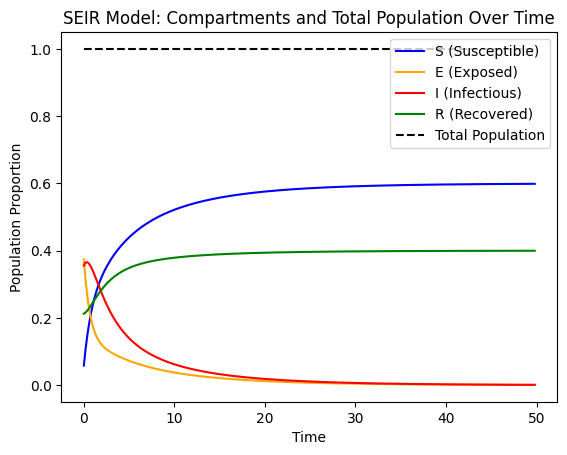

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Load the saved training or testing data (example: loading training data)
data = np.load('seir_training_data.npz')['data']  # You can load 'seird_testing_data.npz' similarly

# Time grid (ensure this matches the one used during data generation)
t = np.arange(0, 50, 0.2)

# Select the simulation you want to plot (e.g., the first simulation, index 0)
simulation_index = 49
S = data[simulation_index, :, 0]  # Susceptible
E = data[simulation_index, :, 1]
I = data[simulation_index, :, 2]  # Infectious
R = data[simulation_index, :, 3]  # Recovered

# Calculate the total population at each time step
total_population = S + E + I + R

# Plot each compartment
plt.plot(t, S, label='S (Susceptible)', color='blue')
plt.plot(t, E, label='E (Exposed)', color = 'orange')
plt.plot(t, I, label='I (Infectious)', color='red')
plt.plot(t, R, label='R (Recovered)', color='green')

# Plot the total population (should be constant if N=1)
plt.plot(t, total_population, label='Total Population', color='black', linestyle='--')

# Labels and title
plt.xlabel('Time')
plt.ylabel('Population Proportion')
plt.title('SEIR Model: Compartments and Total Population Over Time')
plt.legend(loc='best')

# Show the plot
plt.show()
# print(S)